In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler

In [2]:
def n_sphere(point_num, dim):
    r = np.random.normal(5, (0.1)**(dim-1)*5, (1,point_num))   
    coordi = np.ones((dim-1, point_num))              
    for i in range(0, dim-2):                    
        coordi[i] = (np.pi)*np.random.rand(1,point_num)
    coordi[dim-2] = 2*(np.pi)*np.random.rand(1,point_num) 

    point = r * np.ones((dim, point_num)) 
    
    for i in range(0, dim-1):              
        point[i] *= np.cos(coordi[i])
    
    for i in range(1, dim):              
        for j in range(0, i):
            point[i] *= np.sin(coordi[j]) 
        
    point = point.T    
    scaler = MinMaxScaler()
    point = scaler.fit_transform(point)
    return point

In [3]:
def re_data4r(data_arr, delta):
    temp = (data_arr // delta) * delta + delta/2
    return np.array(list(set([tuple(t) for t in temp])))    # Deduplication

def k_meanspp(data_arr,chosen_points):
    kmeans = KMeans(n_clusters=chosen_points, n_init='auto',init='k-means++')
    kmeans.fit(data)
    return kmeans.cluster_centers_

def randomly(data_arr,chosen_points):
    return data_arr[np.random.choice(data_arr.shape[0], chosen_points, replace=False), :]

def maxmin_alg(data_points,chosen_num):
    idx = np.random.choice(data_points.shape[0],1)
    chosen_points = [data_points[idx[0],:]]
    data_points = np.delete(data_points, idx, axis=0)

    while chosen_num != len(chosen_points):
        ft_dict = {}
        for pt_idx, pt in enumerate(data_points):
            ft_dict[pt_idx] = np.min([np.linalg.norm(pt-chosen_pt) for chosen_pt in chosen_points])
            idx = max(ft_dict, key=ft_dict.get)
        chosen_points += [data_points[idx,:]]
        data_points = np.delete(data_points, idx, axis=0)
    return np.array(chosen_points)

In [4]:
dimension = 2
np.random.seed(0)
data = n_sphere(1000,dimension)
save_time = dict()

In [5]:
# In [20], data_size/chosen_pt >= 20 seems to work quite well for data sampled from a two-dimensional surface.

tick= time.time()
result_cla = re_data4r(data,0.123)      # Check the delta via re_data(data,0.95)
tock = time.time()-tick
save_time['CLA'] = round(tock,6)

tick= time.time()
result_kmeans = k_meanspp(data,50)
tock = time.time()-tick
save_time['KMeans'] = round(tock,6)

tick= time.time()
result_random = randomly(data,50)
tock = time.time()-tick
save_time['random'] = round(tock,6)

tick= time.time()
result_maxmin = maxmin_alg(data,50)
tock = time.time()-tick
save_time['MaxMin'] = round(tock,6)

In [6]:
print(result_cla.shape)
print(result_kmeans.shape)
print(result_random.shape)
print(result_maxmin.shape)

(50, 2)
(50, 2)
(50, 2)
(50, 2)


In [7]:
save_time

{'CLA': 0.001461, 'KMeans': 0.038792, 'random': 0.00021, 'MaxMin': 2.550046}

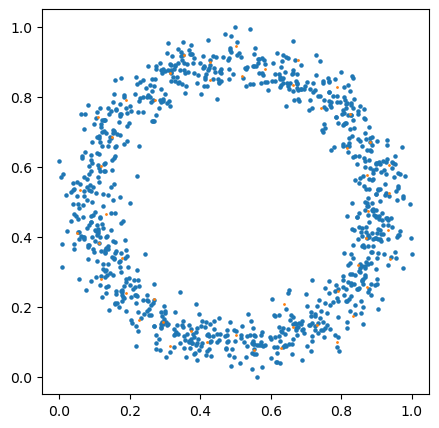

In [8]:
fig = plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1], s=5)
plt.scatter(result_kmeans[:,0],result_kmeans[:,1],s=1)
plt.show()

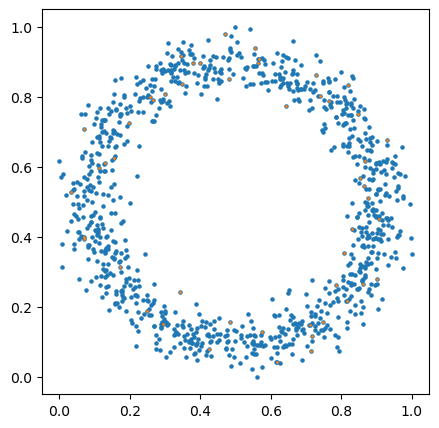

In [9]:
fig = plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1], s=5)
plt.scatter(result_random[:,0],result_random[:,1],s=1)
plt.show()

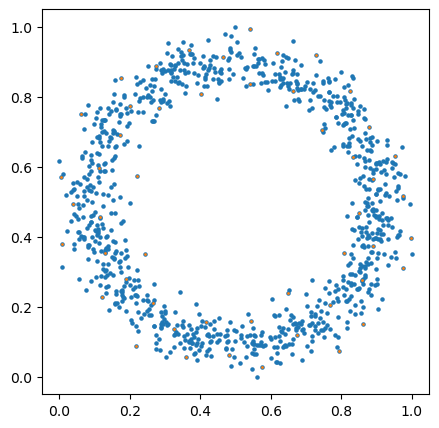

In [10]:
fig = plt.figure(figsize=(5,5))
plt.scatter(data[:,0],data[:,1], s=5)
plt.scatter(result_maxmin[:,0],result_maxmin[:,1],s=1)
plt.show()

---

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [12]:
save_acc = dict()

In [13]:
def plt_check(train_data):
    test = train_data.iloc[0].values
    row = []
    col = []
    for idx, val in enumerate(test):
        if idx % 2 == 0:
            row.append(val)
        else:
            col.append(val)
    fig = plt.figure(figsize=(3,3))
    plt.scatter(row,col,s=1)
    plt.show()

In [14]:
# CLA
temp = np.zeros([10000,100])
for sd in range(5000):
    np.random.seed(sd)
    sphere = n_sphere(1000,2)
    cla_sphere = re_data4r(sphere, 0.11111)[:50,:]
    cla_sphere = cla_sphere.reshape(1,-1)
    temp[sd] = cla_sphere

for sd in range(5000):
    np.random.seed(sd)
    random = np.random.rand(1000, 2)
    cla_random = re_data4r(random, 0.14225)[:50,:]
    cla_random = cla_random.reshape(1,-1)
    temp[5000 + sd] = cla_random

label = [0]*5000 + [1]*5000

X = pd.DataFrame(temp)
y = label

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            test_size=0.2, 
                                            shuffle=True, 
                                            random_state=42,
                                            stratify=y)

svm = SVC()
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)
save_acc['CLA'] = accuracy_score(y_test,y_preds)

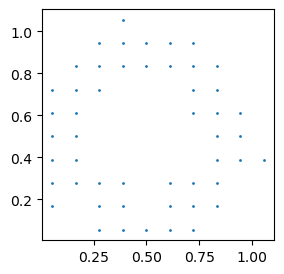

In [15]:
plt_check(X_train)

In [16]:
# KMeans++
temp = np.zeros([10000,100])
for sd in range(5000):
    np.random.seed(sd)
    sphere = n_sphere(1000,2)
    KMeans_sphere = k_meanspp(sphere,50)
    KMeans_sphere = KMeans_sphere.reshape(1,-1)
    temp[sd] = KMeans_sphere

for sd in range(5000):
    np.random.seed(sd)
    random = np.random.rand(1000, 2)
    KMeans_random = k_meanspp(random, 50)
    KMeans_random = KMeans_random.reshape(1,-1)
    temp[5000 + sd] = KMeans_random

label = [0]*5000 + [1]*5000

X = pd.DataFrame(temp)
y = label

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            test_size=0.2, 
                                            shuffle=True, 
                                            random_state=42,
                                            stratify=y)

svm = SVC()
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)
save_acc['KMeans'] = accuracy_score(y_test,y_preds)

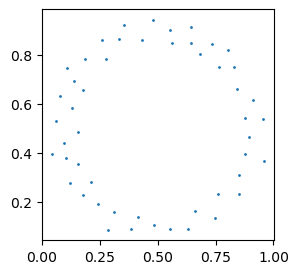

In [17]:
plt_check(X_train)

In [18]:
# randomly
temp = np.zeros([10000,100])
for sd in range(5000):
    np.random.seed(sd)
    sphere = n_sphere(1000,2)
    random_sphere = randomly(sphere,50)
    random_sphere = random_sphere.reshape(1,-1)
    temp[sd] = random_sphere

for sd in range(5000):
    np.random.seed(sd)
    random = np.random.rand(1000, 2)
    random_random = randomly(random, 50)
    random_random = random_random.reshape(1,-1)
    temp[5000 + sd] = random_random

label = [0]*5000 + [1]*5000

X = pd.DataFrame(temp)
y = label

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            test_size=0.2, 
                                            shuffle=True, 
                                            random_state=42,
                                            stratify=y)

svm = SVC()
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)
save_acc['random'] = accuracy_score(y_test,y_preds)

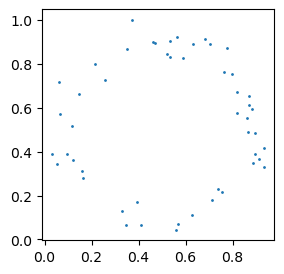

In [19]:
plt_check(X_train)

In [20]:
save_acc

{'CLA': 1.0, 'KMeans': 0.507, 'random': 0.5025}

---

In [ ]:
# MaxMin
# For time reasons, we only use 1000 data for MaxMin instead of 10000 data.

temp = np.zeros([1000,100])
for sd in range(500):
    np.random.seed(sd)
    sphere = n_sphere(1000,2)
    maxmin_sphere = maxmin_alg(sphere,50)
    maxmin_sphere = maxmin_sphere.reshape(1,-1)
    temp[sd] = maxmin_sphere

for sd in range(500):
    np.random.seed(sd)
    random = np.random.rand(1000, 2)
    maxmin_random = maxmin_alg(random, 50)
    maxmin_random = maxmin_random.reshape(1,-1)
    temp[500 + sd] = maxmin_random

label = [0]*500 + [1]*500

X = pd.DataFrame(temp)
y = label

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                            test_size=0.2, 
                                            shuffle=True, 
                                            random_state=42,
                                            stratify=y)

svm = SVC()
svm.fit(X_train, y_train)
y_preds = svm.predict(X_test)
save_acc['MaxMin'] = accuracy_score(y_test,y_preds)

KeyboardInterrupt: 

In [ ]:
plt_check(X_train)

In [ ]:
save_acc